#### Facebook Data Directory
    * nodeId.edges : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

    * nodeId.circles : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

    * nodeId.feat : The features for each of the nodes that appears in the edge file.

    * nodeId.egofeat : The features for the ego user.

    * nodeId.featnames : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt

%matplotlib inline
%precision 4

'%.4f'

In [15]:
from os import path
data_dir = path.join(os.getcwd(), "data")
file_names = glob.glob(path.join(data_dir, "facebook", "*"))

In [55]:
file_tags = set([file_name.split(".")[1] for file_name in file_names])
file_tags = list(file_tags)
file_tags

['edges', 'featnames', 'circles', 'egofeat', 'feat']

"circles": describe formations of circle in terms of memeber (denoted by id)
"egofeat": a single vector of 224 binary indicators (what does the indicator stand for ?) 
"edges": user_id pairs
"feat": user_id, feature vector of 224 binary indicators
"featnames": 224 lines, each line is strucuted like, cetegory, feature, value (e.g. work;start_date;anonymized feature 204)

In [57]:
file_groups = set([file_name.split("\\")[-1].split(".")[0] for file_name in file_names]) 
print("Total of groups: {}".format(len(file_groups)))
file_groups = list(file_groups)
file_groups

Total of groups: 10


['348', '0', '698', '686', '3980', '1684', '414', '107', '3437', '1912']

#### data unstandin:
* Do all featnames include a same set of features ?

In [51]:
featnames_files = [f+".featnames" for f in file_groups]
featnames_files

['348.featnames',
 '0.featnames',
 '698.featnames',
 '686.featnames',
 '3980.featnames',
 '1684.featnames',
 '414.featnames',
 '107.featnames',
 '3437.featnames',
 '1912.featnames']

In [121]:
def feat_extractor(line, group_id):
    items = line.replace("anonymized feature", "").split(" ")
    position = int(items[0])
    feature = items[1][:-1].replace(";", "_")
    value = int(items[2]) 
    return {"group":int(group_id), "position":int(position), \
            "feature":feature, "value":int(value)}

In [122]:
# create data.frame to keep mappig of (circile_id, index, binary vectors) 
# to feature and values
rows = []

for i, file_group in enumerate(file_groups):
    print("{} th loop (ID: {})".format(i, file_group))
    file_name = path.join(data_dir, "facebook", file_group + ".featnames") 
    with open(file_name, mode='r', encoding='utf-8') as fs:
        for line in fs.readlines():
            rows.append(feat_extractor(line, group_id=file_group))

0 th loop (ID: 348)
1 th loop (ID: 0)
2 th loop (ID: 698)
3 th loop (ID: 686)
4 th loop (ID: 3980)
5 th loop (ID: 1684)
6 th loop (ID: 414)
7 th loop (ID: 107)
8 th loop (ID: 3437)
9 th loop (ID: 1912)


In [123]:
import pandas as pd
import numpy as np
feat_dict = pd.DataFrame(rows)
feat_dict.ix[np.random.choice(range(feat_dict.shape[0]), 10), :]
feat_dict.to_csv(path.join(data_dir, "processed", "feature_dict.csv"), 
                 header=True, index=False, sep=",", encoding="utf-8")

In [206]:
circle_feat_dict = feat_dict.ix[feat_dict["group"]==0, :]
circle_feat_dict.head(5)

,feature,group,position,value
161,birthday,0,0,0
162,birthday,0,1,1
163,birthday,0,2,2
164,birthday,0,3,3
165,birthday,0,4,4


In [129]:
feat_dict["feature"].unique()

array(['birthday', 'education_concentration_id', 'education_degree_id',
       'education_school_id', 'education_type', 'education_with_id',
       'education_year_id', 'first_name', 'gender', 'hometown_id',
       'languages_id', 'last_name', 'locale', 'location_id',
       'work_employer_id', 'work_end_date', 'work_location_id',
       'work_position_id', 'work_start_date', 'education_classes_id',
       'work_with_id', 'name', 'political', 'religion', 'middle_name',
       'work_from_id', 'work_projects_id'], dtype=object)

In [265]:
def profile_extracttor(line, circle_id, feat_dict):
    """Convert text line (from .feat data) to dictionary"""
    if isinstance(circle_id, str):
        circle_id = int(circle_id)
    items = line.split(" ")
    user_idx, feature = items[0], list(map(int, items[1:]))
    nonzero_feat_idx = [i for i, val in enumerate(feature) if val == 1]
    feat_dict = feat_dict.ix[feat_dict["group"]==circle_id,\
                             ["feature", "position", "value"]]
    feat_profile =  {row[0]: row[1] \
           for i, row in feat_dict.iterrows() \
           if row[1] in nonzero_feat_idx}
    user_id = "-".join((str(circle_id), str(user_idx)))
    return {"user_id": user_id, "num_filled_feature": len(feat_profile), "profile":feat_profile}

In [266]:
user_profiles = []

for i, file_group in enumerate(file_groups):
    print("{} th loop (circle ID: {})".format(i, file_group))
    file_name = path.join(data_dir, "facebook", file_group + ".feat") 
    with open(file_name, mode='r', encoding='utf-8') as fs:
        for line in fs.readlines():
            res = profile_extracttor(line, file_group, feat_dict)
            user_profiles.append(res)

0 th loop (ID: 348)
1 th loop (ID: 0)
2 th loop (ID: 698)
3 th loop (ID: 686)
4 th loop (ID: 3980)
5 th loop (ID: 1684)
6 th loop (ID: 414)
7 th loop (ID: 107)
8 th loop (ID: 3437)
9 th loop (ID: 1912)


In [267]:
user_profiles = sorted(user_profiles, key=lambda x: int(x["user_id"].split("-")[0]))

In [268]:
import json
with open(path.join(data_dir, "processed", "all_user_profile.json"), mode="w", encoding="utf-8") as f:
    json.dump(user_profiles, f, indent=2)

In [260]:
sorted_user_profiles = sorted(user_profiles, key=lambda x: int(x["user_id"].split("-")[0]))

In [269]:
text = """236 186
122 285
24 346
271 304
176 9
130 329
204 213
252 332
"""

import io

fs = io.StringIO(text)

In [272]:
items = fs.readline().rstrip().split(" ")

In [276]:
items

['24', '346']

In [274]:
circle_id = str(0)
edges = " ".join(['-'.join((circle_id, user_idx)) for user_idx in items])

In [275]:
edges 

'0-24 0-346'

In [295]:
### processing the edge data
### by creating user_id ("circle_id-user_idx")
edges = []

for i, file_group in enumerate(file_groups):
    print("{} th loop (circle ID: {})".format(i, file_group))
    file_name = path.join(data_dir, "facebook", file_group + ".edges") 
    with open(file_name, mode='r', encoding='utf-8') as fs:
        for line in fs.readlines():
            items = line.rstrip().split(" ")
            edge = ['-'.join((file_group, user_idx)) for user_idx in items]
            #edge_str = " ".join(edge)
            edges.append(edge)

0 th loop (circle ID: 348)
1 th loop (circle ID: 0)
2 th loop (circle ID: 698)
3 th loop (circle ID: 686)
4 th loop (circle ID: 3980)
5 th loop (circle ID: 1684)
6 th loop (circle ID: 414)
7 th loop (circle ID: 107)
8 th loop (circle ID: 3437)
9 th loop (circle ID: 1912)


In [299]:
edges = sorted(edges, key=lambda x: int(x[0].split("-")[0]))

In [302]:
with open(path.join(data_dir, "processed", "edges.csv"), mode="w", encoding="utf-8") as f:
     for edge in edges:
            line = ",".join(edge) + "\n"
            f.writelines(line)

In [303]:
feat_dict.head(5)

,feature,group,position,value
0,birthday,348,0,206
1,birthday,348,1,207
2,birthday,348,2,208
3,birthday,348,3,0
4,birthday,348,4,1


In [316]:
## convert profile json to vector 
with open(path.join(data_dir, "processed", "all_user_profile.json"), mode="r", encoding="utf-8") as f:
    user_profiles = json.load(f)

In [319]:
user_profiles[0]["profile"]

{'gender': 77, 'locale': 127}

In [329]:
all_feats = list(feat_dict.feature.unique())
full_profile = {feat:None for feat in all_feats}

user_profile = user_profiles[0]
profile_dict = user_profile["profile"]
for key, val in profile_dict.items():
    full_profile[key] = val
full_profile["user_id"] = user_profile["user_id"]
full_profile["num_filled_feature"] = user_profile["num_filled_feature"]
print(full_profile)

{'education_year_id': None, 'last_name': None, 'education_type': None, 'name': None, 'education_with_id': None, 'education_concentration_id': None, 'education_classes_id': None, 'work_end_date': None, 'work_position_id': None, 'user_id': '0-1', 'work_employer_id': None, 'work_start_date': None, 'num_filled_feature': 2, 'work_projects_id': None, 'education_degree_id': None, 'locale': 127, 'political': None, 'gender': 77, 'religion': None, 'work_from_id': None, 'languages_id': None, 'first_name': None, 'birthday': None, 'location_id': None, 'work_with_id': None, 'education_school_id': None, 'middle_name': None, 'work_location_id': None, 'hometown_id': None}


In [330]:
def map_dict(user_profile_dict, feature_list):
    """Create profile dictionary by including all features"""
    full_profile = {feat:None for feat in all_feats}

    for key, val in user_profile_dict["profile"].items():
        full_profile[key] = val
    full_profile["user_id"] = user_profile_dict["user_id"]
    full_profile["num_filled_feature"] = user_profile_dict["num_filled_feature"]
    return full_profile

In [332]:
users = []
feature_list = list(feat_dict["feature"].unique())

with open(path.join(data_dir, "processed", "all_user_profile.json"), mode="r", encoding="utf-8") as f:
    user_profiles = json.load(f)

for user_dict in user_profiles:
    user = map_dict(user_dict, feature_list=feature_list)
    users.append(user)

In [334]:
user_df = pd.DataFrame(users)

In [335]:
user_df.head(5)

,birthday,education_classes_id,education_concentration_id,education_degree_id,education_school_id,education_type,education_with_id,education_year_id,first_name,gender,...,religion,user_id,work_employer_id,work_end_date,work_from_id,work_location_id,work_position_id,work_projects_id,work_start_date,work_with_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,...,NaN,0-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,35,55,NaN,57,NaN,78,...,NaN,0-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NaN,14,NaN,50,55,NaN,65,NaN,78,...,NaN,0-3,NaN,173,NaN,185,NaN,NaN,217,NaN
3,NaN,NaN,NaN,NaN,50,55,56,NaN,NaN,78,...,NaN,0-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,50,54,NaN,65,NaN,78,...,NaN,0-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [336]:
user_df.columns

Index(['birthday', 'education_classes_id', 'education_concentration_id',
       'education_degree_id', 'education_school_id', 'education_type',
       'education_with_id', 'education_year_id', 'first_name', 'gender',
       'hometown_id', 'languages_id', 'last_name', 'locale', 'location_id',
       'middle_name', 'name', 'num_filled_feature', 'political', 'religion',
       'user_id', 'work_employer_id', 'work_end_date', 'work_from_id',
       'work_location_id', 'work_position_id', 'work_projects_id',
       'work_start_date', 'work_with_id'],
      dtype='object')

In [340]:
ordered_feats = ["user_id", "num_filled_feature"] + [f for f in user_df.columns if f not in ["user_id", "num_filled_feature"]]

In [341]:
user_df = user_df[ordered_feats]

In [343]:
user_df.to_csv(path.join(data_dir, "processed", "user_profile.csv"), header=True, index=False, sep=',')

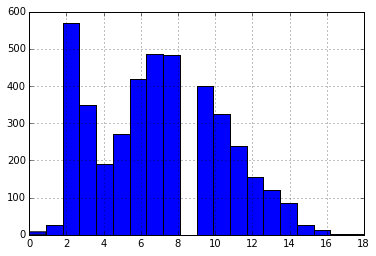

In [346]:
user_df.num_filled_feature.hist(bins=20)